In [1]:
import os
from model import *

## LEAM 
1-layer embeding with label attention, 1-layer mlp for classification

In [2]:
data_dir = 'data/reuters'
vocab_url = os.path.join(data_dir, 'vocab.pkl')
train_url = os.path.join(data_dir, 'train')
test_url = os.path.join(data_dir, 'test')
vocab = pickle.load(open(vocab_url, 'rb'))
vocab = list(zip(*sorted(vocab.items(), key=lambda x: x[1])))[0]
vocab_size = len(vocab)

train_set, train_labels, class_names = dataset(train_url)
test_set, test_labels, _ = dataset(test_url)

model = Leam_Classifier(vocab_size, len(class_names), 256, 256, 10, 
                        n_layer=1, dropout_rate=0.8, embpath=None, label_att=True, multilabel=True)            
trainer = Trainer(batch_size=128, num_epoches=100, learning_rate=1e-3, valid_freq=10, model_type='embed')

trainer.set_vocab(vocab)
trainer.set_validation(test_set, test_labels)
trainer.init_model(model)
train_prob, train_beta = trainer.fit(train_set, train_labels, class_names)

RuntimeError: cublas runtime error : the GPU program failed to execute at /pytorch/aten/src/THC/THCBlas.cu:441

In [ ]:
# validation (test)
val_prob, val_beta = trainer.predict(test_set)
val_pred = val_prob > 0.5
# test not seen in training (task)
task_url = os.path.join(data_dir, 'task')
seq_task, seq_labels, _ = dataset(task_url, monitor=False)
test_prob, test_beta = trainer.predict(seq_task)
test_pred = test_prob > 0.5
multilabel_eval(seq_labels, test_pred, full=True)

In [ ]:
# shwo results and highlights
trains = zip(train_prob>0.5, train_labels, train_set, train_beta)
vals = zip(val_pred, test_labels, test_set, val_beta)
tests = zip(test_pred, seq_labels, seq_task, test_beta)

def write(cache, name, max_len=80, imp=1.5e-2):
    f.write('<p style="background-color:green;">%s</p>'%name)
    for pred, true, sent, recon in cache:
        if (pred[true==1] != 1).all():
            f.write('<p style="background-color:red;">All Miss</p>')
        elif (pred != true).any():
            f.write('<p style="background-color:blue;">Partial Wrong</p>')                    
        f.write('<p>prediction: {}, true: {}</p>'.format(class_names[pred==1], class_names[true==1]))
        f.write('<p>')

        f.write('<p>')
        for i, word in enumerate(sent):
            if i >= max_len:
                break
            if beta[i] > imp:
                f.write('<mark class="red">{}</mark> '.format(vocab[word]))
            else:
                f.write('{} '.format(vocab[word]))                
        f.write('</p>')    
        f.write('<HR SIZE=5>')

        
with open('res.html', 'w', encoding='gbk') as f:
    write(tests, 'Test', max_len=80, imp=1.5e-2)
    write(vals, 'Validation', max_len=80, imp=1.5e-2)
    write(trains, 'Train', max_len=80, imp=1.5e-2)

## Embedding 
1-layer embeding without label attention, 2-layer mlp for classification

In [ ]:
data_dir = 'data/reuters'
vocab_url = os.path.join(data_dir, 'vocab.pkl')
train_url = os.path.join(data_dir, 'train')
test_url = os.path.join(data_dir, 'test')
vocab = pickle.load(open(vocab_url, 'rb'))
vocab = list(zip(*sorted(vocab.items(), key=lambda x: x[1])))[0]
vocab_size = len(vocab)

train_set, train_labels, class_names = dataset(train_url)
test_set, test_labels, _ = dataset(test_url)

model = Leam_Classifier(vocab_size, len(class_names), 256, 256, 10, 
                        n_layer=2, dropout_rate=0.8, embpath=None, label_att=False, multilabel=True)            
trainer = Trainer(batch_size=128, num_epoches=100, learning_rate=1e-3, valid_freq=10, model_type='embed')

trainer.set_vocab(vocab)
trainer.set_validation(test_set, test_labels)
trainer.init_model(model)
train_prob, train_beta = trainer.fit(train_set, train_labels, class_names)

--- epoch: 0 ---
[0/100] loss_epoch : 0.25 val_match : 0.0978 match_epoch : 0.1300 val_hs : 0.1227 hs_epoch : 0.0544
--- epoch: 10 ---
[10/100] loss_epoch : 0.04 val_match : 0.0933 match_epoch : 0.4898 val_hs : 0.1236 hs_epoch : 0.4772
--- epoch: 20 ---
[20/100] loss_epoch : 0.03 val_match : 0.1892 match_epoch : 0.6409 val_hs : 0.4744 hs_epoch : 0.5744
--- epoch: 30 ---
[30/100] loss_epoch : 0.02 val_match : 0.2027 match_epoch : 0.7175 val_hs : 0.5745 hs_epoch : 0.6227
--- epoch: 40 ---
[40/100] loss_epoch : 0.02 val_match : 0.1905 match_epoch : 0.7669 val_hs : 0.6388 hs_epoch : 0.6623


In [ ]:
task_url = os.path.join(data_dir, 'task')
seq_task, seq_labels, _ = dataset(task_url, monitor=False)
test_prob, test_beta = trainer.predict(seq_task)
test_pred = test_prob > 0.5
multilabel_eval(seq_labels, test_pred, full=True)

## Bag of word
2-layer mlp

In [12]:
data_dir = 'data/reuters'
vocab_url = os.path.join(data_dir, 'vocab.pkl')
train_url = os.path.join(data_dir, 'train')
test_url = os.path.join(data_dir, 'test')
vocab = pickle.load(open(vocab_url, 'rb'))
vocab = list(zip(*sorted(vocab.items(), key=lambda x: x[1])))[0]
vocab_size = len(vocab)

# bow
train_set, train_labels, _, class_names = bow_dataset(train_url, vocab_size)
test_set, test_labels, _, _ = bow_dataset(test_url, vocab_size)

model = Classifier(vocab_size, len(class_names), n_layer=2, n_hidden=256, dropout_rate=0.8)
trainer = Trainer(batch_size=128, num_epoches=100, learning_rate=1e-3, valid_freq=10, model_type='bow')

trainer.set_vocab(vocab)
trainer.set_validation(test_set, test_labels)
trainer.init_model(model)
train_prob = trainer.fit(train_set, train_labels, class_names)

--- epoch: 0 ---
[0/100] loss_epoch : 0.25 val_match : 0.0940 match_epoch : 0.1670 val_hs : 0.1553 hs_epoch : 0.0642
--- epoch: 10 ---
[10/100] loss_epoch : 0.03 val_match : 0.0798 match_epoch : 0.6767 val_hs : 0.1705 hs_epoch : 0.5981
--- epoch: 20 ---
[20/100] loss_epoch : 0.02 val_match : 0.2040 match_epoch : 0.7781 val_hs : 0.6282 hs_epoch : 0.6705
--- epoch: 30 ---
[30/100] loss_epoch : 0.02 val_match : 0.2027 match_epoch : 0.8222 val_hs : 0.6947 hs_epoch : 0.7183
--- epoch: 40 ---
[40/100] loss_epoch : 0.01 val_match : 0.2033 match_epoch : 0.8454 val_hs : 0.7298 hs_epoch : 0.7345
--- epoch: 50 ---
[50/100] loss_epoch : 0.01 val_match : 0.2014 match_epoch : 0.8644 val_hs : 0.7543 hs_epoch : 0.7537
--- epoch: 60 ---
[60/100] loss_epoch : 0.01 val_match : 0.2053 match_epoch : 0.8737 val_hs : 0.7648 hs_epoch : 0.7636
--- epoch: 70 ---
[70/100] loss_epoch : 0.01 val_match : 0.2001 match_epoch : 0.8874 val_hs : 0.7644 hs_epoch : 0.7720
--- epoch: 80 ---
[80/100] loss_epoch : 0.01 val_m

In [17]:
task_url = os.path.join(data_dir, 'task')
seq_task, seq_labels, _, _ = bow_dataset(task_url, vocab_size, monitor=False)
test_prob, test_beta = trainer.predict(seq_task)
test_pred = test_prob > 0.5
multilabel_eval(seq_labels, test_pred, full=True)

{'match': 0.23285856243789335,
 'HS': 0.7585126689217447,
 'f1': 0.7763948023217746,
 'HL': 0.005557395752824703,
 'exact_acc': 0.7075190460417357,
 'min_acc': 0.9662139781384564,
 'density_chosen': 0.011092709138419638,
 'density': 0.013779397151374627,
 'precision': 0.7815603510618416,
 'recal': 0.7900960582966946,
 'no_pred': 0.12620072871811858}

## CVAE
bag of word, 1-layer encoder 1-layer decoder
*slow

In [1]:
import os
from zsdm import *

--- epoch: 0 ---
[0/200] loss_epoch : 5.89 val_match : 0.8642 val_hs : 0.3176 match_epoch : 0.8500 hs_epoch : 0.3234
--- epoch: 10 ---
[10/200] loss_epoch : 2.36 val_match : 0.2786 val_hs : 0.6288 match_epoch : 0.2953 hs_epoch : 0.6401
--- epoch: 20 ---
[20/200] loss_epoch : 2.13 val_match : 0.2529 val_hs : 0.6561 match_epoch : 0.2563 hs_epoch : 0.6809
--- epoch: 30 ---
[30/200] loss_epoch : 2.04 val_match : 0.2851 val_hs : 0.6687 match_epoch : 0.2661 hs_epoch : 0.6991
--- epoch: 40 ---
[40/200] loss_epoch : 1.97 val_match : 0.2265 val_hs : 0.6835 match_epoch : 0.2396 hs_epoch : 0.7130
--- epoch: 50 ---
[50/200] loss_epoch : 1.92 val_match : 0.2407 val_hs : 0.6874 match_epoch : 0.2460 hs_epoch : 0.7217
--- epoch: 60 ---
[60/200] loss_epoch : 1.87 val_match : 0.2394 val_hs : 0.6898 match_epoch : 0.2336 hs_epoch : 0.7368
--- epoch: 70 ---
[70/200] loss_epoch : 1.84 val_match : 0.2291 val_hs : 0.6967 match_epoch : 0.2306 hs_epoch : 0.7342
--- epoch: 80 ---
[80/200] loss_epoch : 1.83 val_m

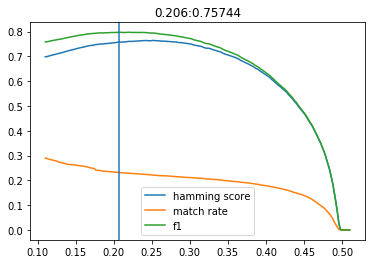

{'match': 0.2315366049879324, 'HS': 0.7574372677470024, 'f1': 0.797125353863085, 'HL': 0.00835076427996782, 'exact_acc': 0.648592115848753, 'min_acc': 0.9290426387771521, 'density_chosen': 0.017009027798970542, 'density': 0.013714132475194422, 'precision': 0.8712529849697992, 'recal': 0.770386615261226, 'no_pred': 0.03153660498793242}


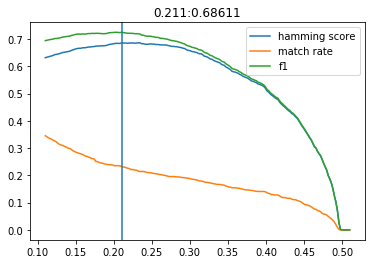

{'match': 0.2323037323037323, 'HS': 0.6861099503956648, 'f1': 0.7247453033167318, 'HL': 0.010367510367510368, 'exact_acc': 0.5823680823680824, 'min_acc': 0.862934362934363, 'density_chosen': 0.016709566116333008, 'density': 0.013677963677963678, 'precision': 0.7936702008130581, 'recal': 0.7010834814399944, 'no_pred': 0.03861003861003861}


<Figure size 432x288 with 0 Axes>

In [6]:
data_dir = 'data/reuters'
vocab_url = os.path.join(data_dir, 'vocab.pkl')
train_url = os.path.join(data_dir, 'train')
test_url = os.path.join(data_dir, 'test')
vocab = pickle.load(open(vocab_url, 'rb'))
vocab = list(zip(*sorted(vocab.items(), key=lambda x: x[1])))[0]
vocab_size = len(vocab)

train_set, train_labels, _, class_names = bow_dataset(train_url, vocab_size)
test_set, test_labels, _, _ = bow_dataset(test_url, vocab_size)

model = ZSDM(vocab_size, len(class_names), n_latent=128, attribute_size=50, 
             dropout_rate=0.8, n_hidden=256, tfidf=False)
trainer = Trainer(batch_size=128, num_epoches=200, n_latent=128, n_topic=len(class_names), 
                  learning_rate=1e-3, valid_freq=10, model_type='bow')

trainer.set_vocab(vocab)
trainer.set_validation(test_set, test_labels)
trainer.init_model(model)
train_prob, test_prob, train_threshold, test_threshold = trainer.fit(train_set, train_labels, class_names)

In [8]:
task_url = os.path.join(data_dir, 'task')
seq_task, seq_labels, _, _ = bow_dataset(task_url, vocab_size, monitor=False)
test_probs = trainer.compute_prob(seq_task)
test_pred, threshold, score = trainer.find_class(test_probs, seq_labels, threshold=test_threshold)
print(score)

{'match': 0.27393176548526, 'HS': 0.6766484086374779, 'f1': 0.7142140761965208, 'HL': 0.012447094328512015, 'exact_acc': 0.5809870818151706, 'min_acc': 0.8906922822126532, 'density_chosen': 0.018519745932685003, 'density': 0.013779397151374627, 'precision': 0.7919632371603224, 'recal': 0.6888518946727366, 'no_pred': 0.03544219940377608}
